In [7]:
from itertools import islice
import random
import math
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import torch
from torch import nn
import pandas as pd
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torch.utils.tensorboard import SummaryWriter
import time
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
datasetCsv = pd.read_csv('dataset.csv')
# drop id column because it can't be a feature to train
datasetCsv.drop(columns=["Id"], axis= 1, inplace=True)
#replace zeros with NaN 
fields_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in fields_with_invalid_zeros:
    datasetCsv[col] = datasetCsv[col].apply(lambda x: np.nan if x == 0 else x)

#impute values
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(datasetCsv), columns=datasetCsv.columns)

#normalize feature columns (excluding the target)
X = df_imputed.drop(columns=['Outcome'])
y = df_imputed['Outcome']
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#combine features and label into one DataFrame

preprocessed_df = X_scaled.copy()
preprocessed_df['Outcome'] = y
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

preprocessed_df = pd.DataFrame(X_resampled, columns=X.columns)
preprocessed_df['Outcome'] = y_resampled
preprocessed_df.head()

class CustomDataset(Dataset):
    def __init__(self, dataFrane):
        self.data = dataFrane
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        features = torch.tensor(row[:-1].values, dtype=torch.float32)
        label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]
        return features, label
    
customDataset = CustomDataset(preprocessed_df)

trainData, testData = random_split(customDataset, [0.8, 0.2])
print(len(trainData))
print(len(testData))
trainDataLoader = DataLoader(trainData, batch_size=64, shuffle=True)
testDataLoader = DataLoader(testData, batch_size=64, shuffle=False)

2906
726


In [9]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def compute_accuracy(network, dataloader, device):
    """Computes accuracy of `network` on `dataloader`.
    """
    with torch.no_grad():
        correct = 0
        total = 0
        for x, labels in dataloader:
            logits = network(x.to(device))
            predicted_labels = (torch.sigmoid(logits) > 0.5).float()
            correct += torch.sum(predicted_labels == labels.to(device))
            total += x.size(0)
        return (correct / total).item()

def compute_loss(network, dataloader, device):
    """Computes mean loss of `network` on `dataloader`.
    """
    with torch.no_grad():
        loss_fn = nn.BCEWithLogitsLoss()
        total = 0
        points = 0
        for x, labels in dataloader:
            y = network(x.to(device))
            total += loss_fn(y, labels.to(device)).item()
            points += x.size(0)
        return total / points

class MLP(nn.Module):
    def __init__(self, input_size=8, hidden_size=200):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)  # Binary classification
        )

    def forward(self, x):
        return self.layers(x)

# Using fixed configurations: ReLU activation, Adam optimizer, BCEWithLogitsLoss

optimization_steps = 100000
weight_decay = 0.01
lr = 1e-3
initialization_scale = 1.0  # Reduced for binary classification

depth = 3               # the number of nn.Linear modules in the model
width = 200

log_freq = math.ceil(optimization_steps / 150)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32  # Changed to float32 for better compatibility
seed = 0

torch.set_default_dtype(dtype)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

# create model
mlp = MLP(input_size=8, hidden_size=200).to(device)  # 8 features for diabetes dataset
with torch.no_grad():
    for p in mlp.parameters():
        p.data = initialization_scale * p.data

# create optimizer
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr, weight_decay=weight_decay)

# define loss function
loss_fn = nn.BCEWithLogitsLoss()  # Better for binary classification

# Initialize TensorBoard writer
writer = SummaryWriter('runs/diabetes_experiment')

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
norms = []
last_layer_norms = []
log_steps = []

steps = 0
for x, labels in islice(cycle(trainDataLoader), optimization_steps):
        if (steps < 30) or (steps < 150 and steps % 10 == 0) or steps % log_freq == 0:
            train_loss = compute_loss(mlp, trainDataLoader, device)
            train_acc = compute_accuracy(mlp, trainDataLoader, device)
            test_loss = compute_loss(mlp, testDataLoader, device)
            test_acc = compute_accuracy(mlp, testDataLoader, device)
            
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
            log_steps.append(steps)
            
            # Log to TensorBoard
            writer.add_scalar('Loss/Train', train_loss, steps)
            writer.add_scalar('Loss/Test', test_loss, steps)
            writer.add_scalar('Accuracy/Train', train_acc, steps)
            writer.add_scalar('Accuracy/Test', test_acc, steps)
            
            with torch.no_grad():
                total = sum(torch.pow(p, 2).sum() for p in mlp.parameters())
                weight_norm = float(np.sqrt(total.item()))
                last_layer = sum(torch.pow(p, 2).sum() for p in mlp.layers[-1].parameters())
                last_layer_norm = float(np.sqrt(last_layer.item()))
                
                norms.append(weight_norm)
                last_layer_norms.append(last_layer_norm)
                
                # Log weight norms to TensorBoard
                writer.add_scalar('Weight_Norm/Total', weight_norm, steps)
                writer.add_scalar('Weight_Norm/Last_Layer', last_layer_norm, steps)

        optimizer.zero_grad()
        y = mlp(x.to(device))
        loss = loss_fn(y, labels.to(device))
        loss.backward()
        optimizer.step()
        steps += 1

# Close TensorBoard writer
writer.close()
print("Training completed! To view TensorBoard, run: tensorboard --logdir=runs")
    

/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_21007/1758246225.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]


Training completed! To view TensorBoard, run: tensorboard --logdir=runs


Text(0.5, 1.0, 'depth-3 width-200 ReLU MLP on Diabetes Dataset\nUnconstrained Optimization α = 1.0')

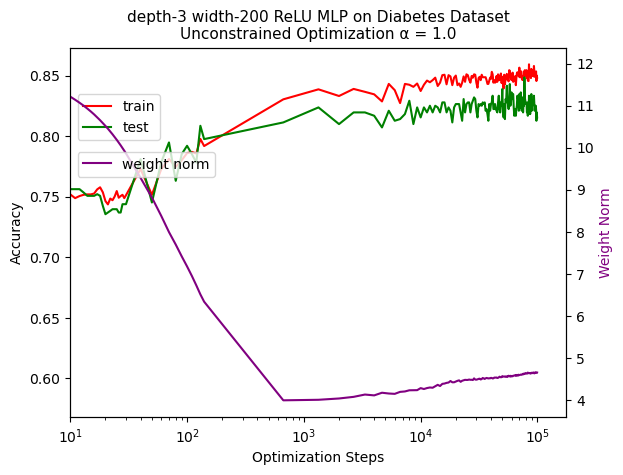

In [10]:
ax = plt.subplot(1, 1, 1)
plt.plot(log_steps, train_accuracies, color='red', label='train')
plt.plot(log_steps, test_accuracies, color='green', label='test')
plt.xscale('log')
plt.xlim(10, None)
plt.xlabel("Optimization Steps")
plt.ylabel("Accuracy")
plt.legend(loc=(0.015, 0.75))

ax2 = ax.twinx()
ax2.set_ylabel("Weight Norm", color='purple')
ax2.plot(log_steps, norms, color='purple', label='weight norm')
# ax2.set_ylim(27, 63)
plt.legend(loc=(0.015, 0.65))
plt.title(f"depth-3 width-200 ReLU MLP on Diabetes Dataset\nUnconstrained Optimization α = {initialization_scale}", fontsize=11)
# plt.tight_layout()